In [1]:
import numpy as np
import cv2   as cv
import math

from IPython.display import Image
from matplotlib      import pyplot as plt

from helpers import (
    show_image,
    load_image
)

In [235]:
def show_image(image):
    """
    Stores first a version in the hard drive with a name generated from the current
    timestamp, then display it using jupyter builtin function Image
    """
    current_timestamp = datetime.now()
    extension = '.jpg' # auto handled by opencv.
    filename = re.sub(r'\D', '_', str(current_timestamp)) + extension
    temporary_directory = 'temporary_pics'
    file_path = path.join(temporary_directory, filename)

    cv.imwrite(file_path, image)
    return Image(file_path)

def load_image(filename):
    pics_directory = 'pics'
    # for portable code between different platforms.
    file_path = path.join(pics_directory, filename)
    return cv.imread(file_path, 0)

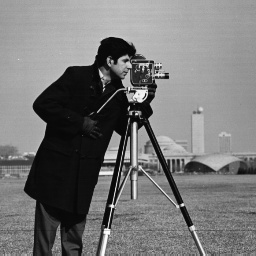

In [2]:
filename = 'cameraman.tif'
image = load_image(filename)
show_image(image)

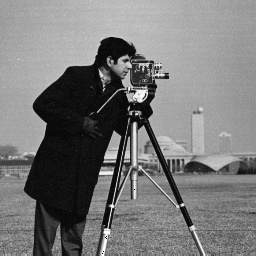

In [3]:
# Apply gausian noise, no imnoise exists in python opencv2 api (at least version 4)
noise = np.zeros(image.shape, dtype=np.uint8)
noise = cv.randn(noise, 0, 5)

image += noise
show_image(image)

# Spatial filtering
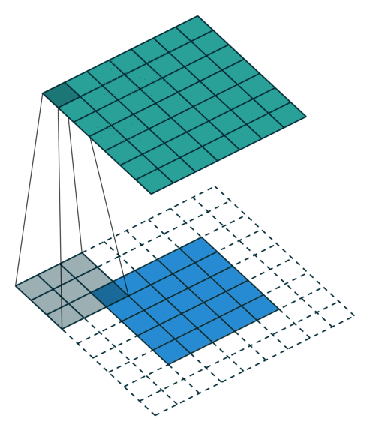

## Linear spatial filtering
**1. Programmer une fonction filtre_Moy(image) permettant de réaliser lissage par moyennage dans un voisinage 3x3, appliquez là sur  l’image bruitée. généraliser pour un voisinage de (n,m).**

In [27]:
def apply_filter(image, kernel):
    kernel_width, kernel_height = kernel.shape
    
    # Check kernel dimensions -> must be impair.
    if not (kernel_width % 2 and kernel_height % 2):
        raise ValueError('Kernel should have imprair dimensions')

    result = np.zeros(image.shape)
    
    # calculate image padding
    top = bottom = kernel_height - 1
    left = right = kernel_width -1  
    
    # generate image with padding and the original image at the center
    image = cv.copyMakeBorder(image, top, bottom, left, right, cv.BORDER_CONSTANT, value=0)

    height, width = result.shape

    for i in range(height):
        for j in range(width):
            result[i][j] = np.sum(image[i:i+kernel_width, j:j+kernel_height] * kernel)

    return result

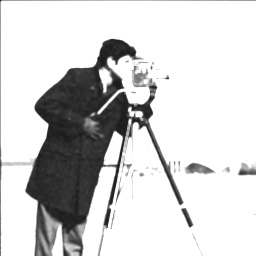

In [37]:
# Testing the above function.
kernel = np.ones((3,3),np.float32)/3
processed_image = apply_filter(image, kernel)
show_image(processed_image)

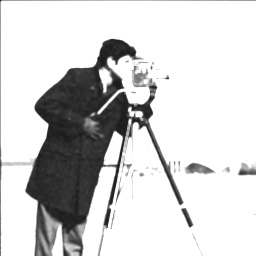

In [38]:
# using opencv2 api to compare results
dst = cv.filter2D(image,-1,kernel)
show_image(processed_image)

**2. Programmer une fonction filtrage(image,H) permettant de réaliser un filtrage avec le filtre H.**

Response: Please take a look at the definition of apply_filter above

* Tester sur l’image bruitée un filtre passe bas H = 1/16*[1,2,1;2,4,2;1,2,1].

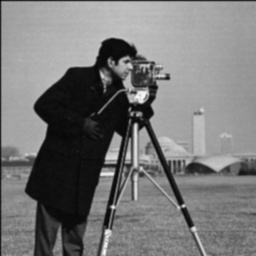

In [47]:
# Testing with a low filter
kernel = np.array([[1,2,1],[2,4,2], [1,2,1]], np.float16) / 16
processed_image = apply_filter(image, kernel)
show_image(processed_image)

* Tester sur l’image bruitée un filtre passe haut H= [-1,-1,-1;-1,8,-1;-1,-1,-1].

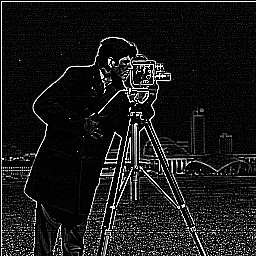

In [71]:
# Testing with a high filter
kernel = np.array(
    [
        [-1,-1,-1], 
        [-1, 8,-1],
        [-1,-1,-1]
    ], 
    np.float16
)

processed_image = apply_filter(image, kernel)
show_image(processed_image)

## Non-linear spatial filter

1. Programmer une fonction  lissage_MinMax(image) réalisant  le lissage selon la méthode Min Max.

In [87]:
# Let's refactore the apply_filter to account for desired function
def lissage_min_max(image, kernel):
    kernel_width, kernel_height = kernel.shape
    
    # Check kernel dimensions -> must be impair.
    if not (kernel_width % 2 and kernel_height % 2):
        raise ValueError('Kernel should have imprair dimensions')

    result = np.zeros(image.shape)
    
    # calculate image padding
    top = bottom = kernel_height - 1
    left = right = kernel_width -1  
    
    # generate image with padding and the original image at the center
    image = cv.copyMakeBorder(image, top, bottom, left, right, cv.BORDER_CONSTANT, value=0)

    height, width = result.shape

    for i in range(height):
        for j in range(width):
            window = image[i:i+kernel_width, j:j+kernel_height] * kernel
            window_max, window_min = window.max(), window.min()
            threshold = (window_max - window_min) // 2
            pixel = result[i][j]
            result[i][j] = window_max if pixel > threshold else window_min

    return result

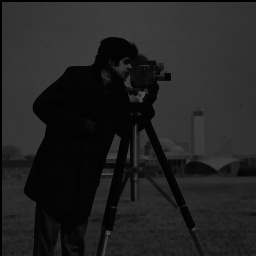

In [82]:
# Testing the above function
kernel = np.ones((3,3),np.float32)/3
processed_image = lissage_min_max(image, kernel)
show_image(processed_image)

2. Programmer une fonction lissage_Median(image,n,m)permettant d’appliquer un filtrage médian sur une fenêtre de nxm

In [223]:
def lissage_median(image, kernel):
    kernel_width, kernel_height = kernel.shape
    
    # Check kernel dimensions -> must be impair.
    if not (kernel_width % 2 and kernel_height % 2):
        raise ValueError('Kernel should have imprair dimensions')

    result = np.zeros(image.shape)
    
    # calculate image padding
    top = bottom = kernel_height - 1
    left = right = kernel_width -1  
    
    # generate image with padding and the original image at the center
    image = cv.copyMakeBorder(image, top, bottom, left, right, cv.BORDER_CONSTANT, value=0)

    height, width = result.shape

    for i in range(height):
        for j in range(width):
            result[i][j] = np.median(image[i:i+kernel_width, j:j+kernel_height] * kernel)

    return result

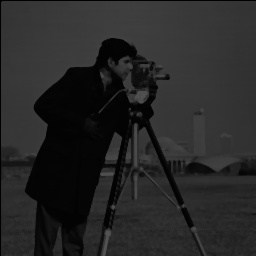

In [224]:
# Testing the above function
kernel = np.ones((3,3),np.float32)/3
processed_image = lissage_median(image, kernel)
show_image(processed_image)

**3. Programmer une fonction permettant d’appliquer un filtrage médian hybride sur une fenêtre de 5x5 (principe ci-dessous), appliquer la sur l’image bruitée et déduire le rôle de ce type de filtre. C’est un lissage où la valeur du pixel est la médiane de ces trois médianes à savoir : croix, diagonale + pixel central**


In [221]:
def lissage_hyprid_median(image, kernel):
    kernel_width, kernel_height = kernel.shape
    
    # Check kernel dimensions -> must be impair.
    if not (kernel_width == 5 and kernel_height == 5):
        raise ValueError('Kernel should have imprair dimensions')

    result = np.zeros(image.shape)
    
    # calculate image padding
    top = bottom = kernel_height - 1
    left = right = kernel_width -1  
    
    # generate image with padding and the original image at the center
    image = cv.copyMakeBorder(image, top, bottom, left, right, cv.BORDER_CONSTANT, value=0)

    height, width = result.shape

    for i in range(height):
        for j in range(width):
            window = image[i:i+kernel_width, j:j+kernel_height] * kernel
            diagonal = np.concatenate([np.diag(window), np.diag(np.transpose(window))])
            cross    = np.concatenate([window[:,2].flatten(), window[2].flatten()])
            pixel    = window[2,2]
            hyprid_median = sorted([np.median(diagonal), np.median(cross), pixel])[1]
            result[i,j] = hyprid_median
 
    return result

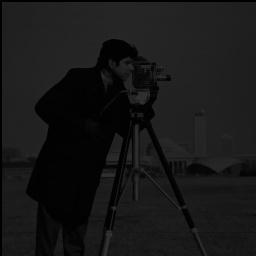

In [222]:
# Testing the above function
kernel = np.ones((5,5),np.float32)/5
processed_image = lissage_hyprid_median(image, kernel)
show_image(processed_image)

The hyprid median filter removes impulse noise while preserving edges.

**4. Le filtre de Nagao**

In [199]:
# constructs masks
mask_ref_01 = np.array(
    [[1, 1, 1, 0, 0], [1, 1, 1, 0, 0], [1, 1, 1, 0, 0], [0, 0, 0, 0, 0], [0, 0, 0, 0, 0]], 
    np.float32
)

mask_ref_02 = np.array(
    [[1, 0, 0, 0, 0], [1, 1, 0, 0, 0], [1, 1, 1, 0, 0], [1, 1, 0, 0, 0], [1, 0, 0, 0, 0]], 
    np.float32
)

center_mask = np.zeros((5,5), np.float32)
center_mask[1:4,1:4]=1

masks = [center_mask, ]

for w in (mask_ref_01, mask_ref_02):
    masks.append(w)
    masks.append(cv.rotate(w, cv.ROTATE_90_CLOCKWISE))
    masks.append(cv.rotate(w, cv.ROTATE_180))
    masks.append(cv.rotate(w, cv.ROTATE_90_COUNTERCLOCKWISE))

masks = [np.ma.masked_equal(window,0) for window in masks]

In [233]:
def filter_nagao(image):
    kernel = np.ones((5,5), np.float32)
    kernel_width, kernel_height = kernel.shape

    result = np.zeros(image.shape)
    
    # calculate image padding
    top = bottom = kernel_height - 1
    left = right = kernel_width -1 
    
    # generate image with padding and the original image at the center
    image = cv.copyMakeBorder(image, top, bottom, left, right, cv.BORDER_CONSTANT, value=0)

    height, width = result.shape

    for i in range(height):
        for j in range(width):
            window = image[i:i+kernel_width, j:j+kernel_height] * kernel
            
            var_to_mean_mapping = {} # store mapping var -> mean

            for mask in masks:
                masked_window = window + mask
                window_avg = np.average(masked_window)
                window_var = np.var(masked_window)
                var_to_mean_mapping[window_var] = window_avg
                
            # Fetch min var
            min_window_var = min(var_to_mean_mapping.keys())
            
            # Assing the average
            result[i, j] = var_to_mean_mapping[min_window_var]
            
    return result

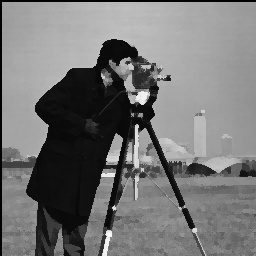

In [234]:
# Testing the above function
processed_image = filter_nagao(image)
show_image(processed_image)

**Result: The Nagao filter retain the linear features throught the smoothing process and doesn't retain so much the non-linear features**

## Frequency filtering

In [4]:
# Will be commited shortly